In [1]:
%matplotlib notebook

from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy                import integrate
from scipy                import signal
from scipy                import stats
from scipy.optimize       import curve_fit

import glob
import os
from astropy.io           import fits

os.environ['pandeia_refdata'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/pandeia_data"
os.environ['PYSYN_CDBS'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/cdbs.23.1.rc3"

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc
import numpy as np

import matplotlib.pylab as plt

In [2]:
'''
Interstellar medium transmission function
'''


table = np.loadtxt('data/table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]
F_ISM = interp2d(z, lam_rest, trans_coef)



'''
Luminosity tables as a function of metallicity Z and stars' birth time t
'''

muf_list = sorted(glob.glob("data/drt/muv.bin*"))
lam_list = np.zeros(len(muf_list))
lookup = np.zeros([len(muf_list), 188, 22])

for i in range(len(muf_list)):
    f = open(muf_list[i])
    header = f.readline()
    lam_list[i] = float(header.split()[2])

    f.close()

    data = np.genfromtxt(muf_list[i], skip_header=1)
    lookup[i, :, :] = data[1:,1:]

Z = data[0, 1:]  # metallicity [Sun_Z]
logt = data[1:, 0]  # log10(t) [yr]


def filter_bandwidth(a, b, x):

    position_in_lam_array = []

    for i in range(0,len(x)):
        if a <=x[i] and x[i] <= b:
            if F_filter(x[i])>=0.5e-3:
                position_in_lam_array.append(i)

    return position_in_lam_array


def JWST_filter_init(z, filter_name):

    '''
    James Webb Space Telescope filter initialization function
    '''

    global F_filter

    wavelengths, transmission = np.loadtxt('data/filter_' + filter_name + '.dat',skiprows=1).T
    wavelengths *= 1e4
    F_filter = interp1d(wavelengths, transmission,fill_value=0.0,bounds_error=False)
    a,b = np.min(wavelengths),np.max(wavelengths)
    lamb_positions = filter_bandwidth(a,b,lam_list*(1+z))
    return lamb_positions

<IPython.core.display.Javascript object>


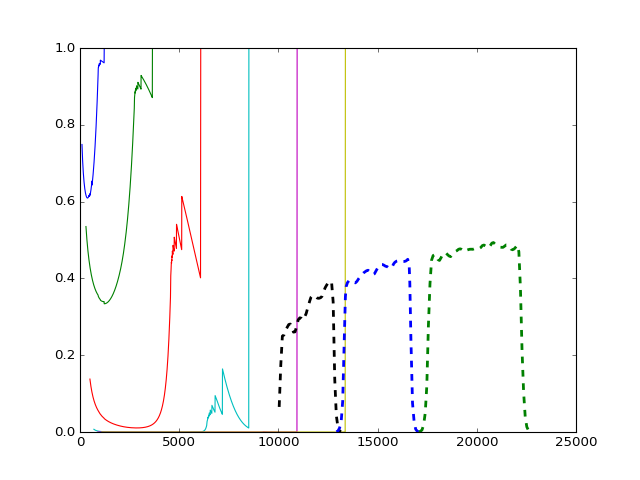

In [3]:
plt.figure(1)
redshift = 7
for i in range(0,12,2):
    plt.plot(lam_rest*(i+1),F_ISM(i,lam_rest),label='z = ' + str(i))
for filter_name in ['F115W','F150W','F200W']:
    lamb_positions = JWST_filter_init(filter_name=filter_name,z=redshift)
    lamb_filter = lam_list[lamb_positions]
    plt.plot(lamb_filter*(1+redshift),F_filter(lamb_filter*(1+redshift)),'--',lw=2.5)

<IPython.core.display.Javascript object>


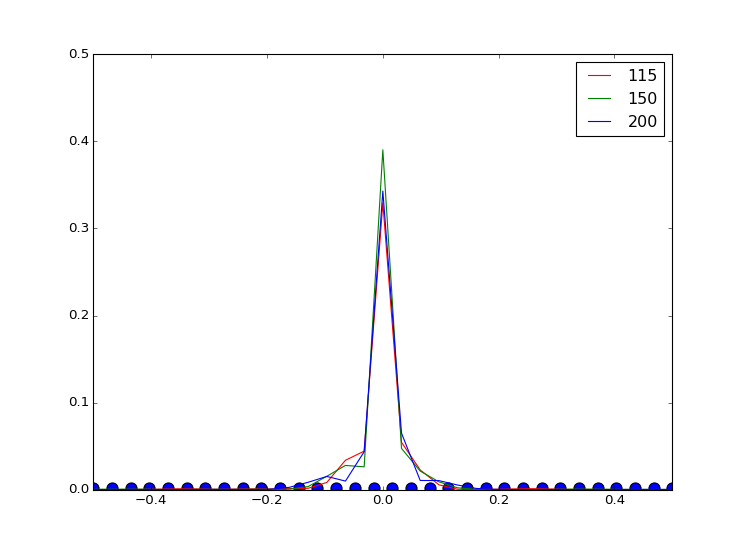

2.976
2.976
2.976
0.97211760751
0.967167404854
0.961026329275
(93, 93)


In [4]:
# PSF
A = fits.open('data/PSF_NIRCam_F115W.fits')[0].data
B = fits.open('data/PSF_NIRCam_F150W.fits')[0].data
C = fits.open('data/PSF_NIRCam_F200W.fits')[0].data

coords_A = np.linspace(-1.5 + 1.5/np.shape(A)[0],1.5 - 1.5/np.shape(A)[0],np.shape(A)[0])
coords_B = np.linspace(-1.5 + 1.5/np.shape(B)[0],1.5 - 1.5/np.shape(B)[0],np.shape(B)[0])
coords_C = np.linspace(-1.5 + 1.5/np.shape(C)[0],1.5 - 1.5/np.shape(C)[0],np.shape(C)[0])

JWST_NIRCAM_pixel_size = 0.032  # arcsec per pixel
NNbins = int(3/JWST_NIRCAM_pixel_size)
pix_edges  = np.linspace(-1.5,1.5,NNbins+1)

x, y = np.meshgrid(coords_A, coords_A)
psf_F115W,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = A.flatten())
x, y = np.meshgrid(coords_B, coords_B)
psf_F150W,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = B.flatten())
x, y = np.meshgrid(coords_C, coords_C)
psf_F200W,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = C.flatten())

plt.figure(2)
bins = (pix_edges[:-1] + pix_edges[1:])/2
plt.plot(bins, psf_F115W[46,:],'r',label='115')
plt.plot(bins, psf_F150W[46,:],'g',label='150')
plt.plot(bins, psf_F200W[46,:],'b',label='200')
plt.scatter(pix_edges,np.ones(len(pix_edges))/5e2,s=100)
plt.ylim(0,0.5)
plt.xlim(-0.5,0.5)
plt.legend()

plt.show()

print(np.shape(psf_F115W)[0]*JWST_NIRCAM_pixel_size)
print(np.shape(psf_F150W)[0]*JWST_NIRCAM_pixel_size)
print(np.shape(psf_F200W)[0]*JWST_NIRCAM_pixel_size)

print(np.sum(psf_F115W))
print(np.sum(psf_F150W))
print(np.sum(psf_F200W))
print(np.shape(psf_F115W))

In [5]:
coll_area    = 254009.0 # cm2
c            = 2.9927e10
maximum = [1.15,1.5,2.0]
normalization = np.zeros(3)
for name,i in zip(['F115W','F150W','F200W'],[0,1,2]):
    filter_JWST   = np.loadtxt('data/filter_' + name + '.dat',skiprows=1)
    x = np.linspace(0.1,3,500)
    print(maximum[i])
    y = stats.norm.pdf(x,loc=maximum[i],scale=0.05) * 1e-3
    F_JWST = interp1d(filter_JWST[:,0],filter_JWST[:,1],fill_value=0.0,bounds_error=False)
    photons_wave  = coll_area * 1.5091905 * y / x
    photons_norm  = coll_area * 1.5091905 * 1 / x
    normalization[i] = integrate.trapz(F_JWST(x)*photons_norm,x)
    
    print(1e6/normalization[i])

1.15
34.0839263509
1.5
27.1888929926
2.0
22.9622119322


In [11]:
# to generate spectrum

x = np.linspace(0.1,3,500)
y = stats.norm.pdf(x,loc=1.5,scale=0.05) * 1e-26

def func_trial(x,a,b):
    return stats.norm.pdf(x,loc=a, scale=b)
    
number_of_exp2 =  np.logspace(0,np.log10(16144),30) 

loc2 = np.zeros((3,len(number_of_exp2)))
scale2 = np.zeros((3,len(number_of_exp2)))
on_source_time2 = np.zeros((3,len(number_of_exp2)))

for name,j in zip(['f115w','f150w','f200w'],[0,1,2]):
    for i in range(0,len(number_of_exp2)):
        
        calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

        spec = [x,y]

        calc_input['scene'][0]['spectrum']['sed'] = {"sed_type": "input", "spectrum": spec}
        calc_input['scene'][0]['spectrum']['normalization']['type'] = 'none'
        calc_input['configuration']['max_scene_size'] = 30

        calc_input['background'] = 'low'

        calc_input['configuration']['instrument']['filter'] = name
        calc_input['configuration']['detector']['nexp'] = number_of_exp2[i]

        calc_input['strategy']['aperture_size'] = 0.1
        calc_input['strategy']['sky_annulus'] = [0.7, 0.9]


        report = perform_calculation(calc_input, dict_report=False, webapp=True)
        report_dict = report.as_dict()
        report_fits = report.as_fits()

        flux = 1e6*report_dict['2d']['detector']/normalization[j]
        on_source_time2[j,i] = report_dict['scalar']['on_source_time']
        
        shape  = np.shape(report_dict['2d']['detector'])[0]
        sample = np.array(flux).reshape(shape*shape)
        pdf = stats.gaussian_kde(sample)
        grid_points_pdf = pdf.evaluate(sample)
        
        popt, pcov = curve_fit(func_trial, sample, grid_points_pdf)

        loc2[j,i] = popt[0]
        scale2[j,i] = popt[1]
    print(name)

/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


f115w
f150w
f200w


In [21]:
x = np.linspace(0.5,2.5,200)
y = stats.norm.pdf(x,loc=2,scale=0.05) * 1e-3

calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

#The 0th index is taken to be wavelength in units of 'mJy'.
#The 1st index is taken to be the flux in units of 'microns'.
spec = [x,y]
    
calc_input['scene'][0]['spectrum']['sed'] = {"sed_type": "input", "spectrum": spec}
calc_input['scene'][0]['spectrum']['normalization']['type'] = 'none'
calc_input['configuration']['max_scene_size'] = 30


calc_input['background'] = 'low'

calc_input['configuration']['instrument']['filter'] = 'f200w'
calc_input['configuration']['detector']['nexp'] = 1

calc_input['strategy']['aperture_size'] = 0.1
calc_input['strategy']['sky_annulus'] = [0.7, 0.9]


report = perform_calculation(calc_input, dict_report=False, webapp=True)
report_dict2 = report.as_dict()
report_fits2 = report.as_fits()

print(report_dict2['scalar'])

/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


{'background_sky': 6.0389750268967095, 'contamination': 0.006558425767656261, 'background_area': 981.74770424681026, 'extracted_noise': 0.2509684050761647, 'disperser': None, 'background': 0.18318637221199571, 'sn': 250.19027560748546, 'filter': 'f200w', 'x_offset': 0.0, 'extraction_area': 30.679615757712813, 'cr_ramp_rate': 0.1551109231922884, 'extracted_flux': 62.7898544347767, 'background_total': 6.0788426652701455, 'aperture_size': 0.1, 'all_dithers_time': 1954.68, 'y_offset': 0.0, 'reference_wavelength': 1.9992087769379439, 'on_source_time': 1954.68}


(3, 30)


<IPython.core.display.Javascript object>


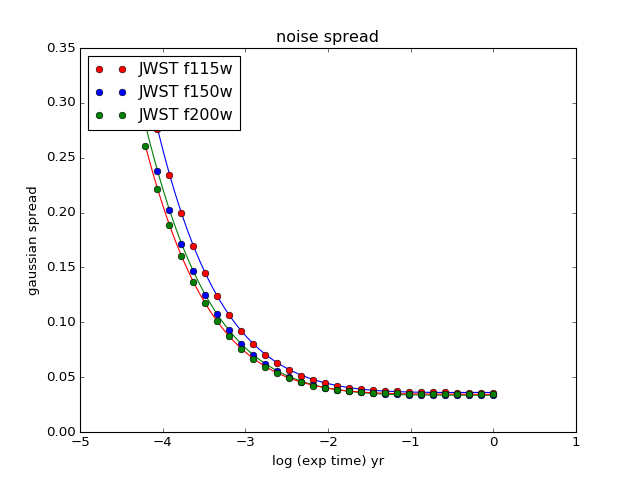

[  -0.38425561    9.91023494  -83.24295973  285.06457776 -306.59387461]
[  -0.35863568    9.11371203  -75.59702458  256.43663237 -275.12240768]
[  -0.36536499    9.14144209  -74.73426839  250.6354125  -267.83637018]


In [19]:
def func_trial_2(x,a,b,c,d,e):
    X = np.log10(x)
    return a + b/X + c/X/X + d/X/X/X + e/X/X/X/X
yr_in_sec = 31536000
print(np.shape(scale2))

plt.figure(5)
plt.title('noise spread')
for name,i,colors in zip(['f115w','f150w','f200w'],[0,1,2],['red','blue','green']):
    popt, pcov = curve_fit(func_trial_2,on_source_time2[i,:], scale2[i,:])
    print(popt)
    sample = np.logspace(np.log10(on_source_time2[i,0]),np.log10(on_source_time2[i,-1]),500)
    plt.plot(np.log10(sample/yr_in_sec),func_trial_2(sample,*popt))
    plt.plot(np.log10(np.array(on_source_time2[i,:])/yr_in_sec),scale2[i,:],'o',c=colors,label='JWST ' + name)
plt.xlabel('log (exp time) yr')
plt.ylabel('gaussian spread')
plt.legend(loc='upper left')

<IPython.core.display.Javascript object>


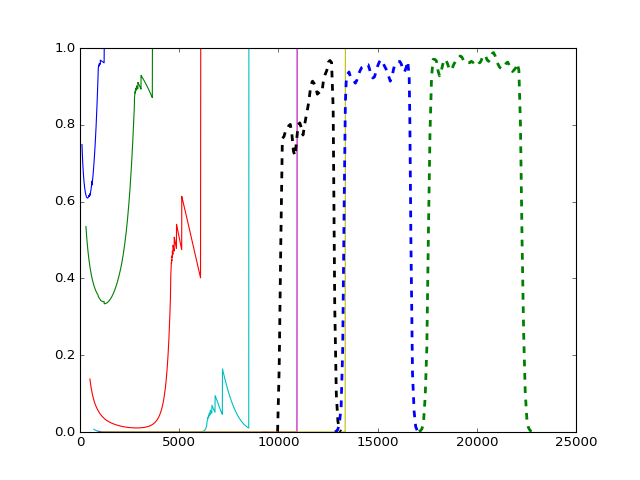

In [4]:
plt.figure(4)
redshift = 7
for i in range(0,12,2):
    plt.plot(lam_rest*(i+1),F_ISM(i,lam_rest),label='z = ' + str(i))
for filter_name in ['F115W2','F150W2','F200W2']:
    lamb_positions = JWST_filter_init(filter_name=filter_name,z=redshift)
    lamb_filter = lam_list[lamb_positions]
    plt.plot(lamb_filter*(1+redshift),F_filter(lamb_filter*(1+redshift)),'--',lw=2.5)

In [12]:
print(JWST_noise_spread(x=(60*60*30),filt='150'))

150
0.0504258689564
